In [1]:
from keras.models import Model
from keras.layers import Flatten, Dense, Dropout
import tensorflow as tf
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator

# 資料路徑
DATASET_PATH  = 'sample'

# 影像大小
IMAGE_SIZE = (380, 380)

# 影像類別數
NUM_CLASSES = 2

# 若 GPU 記憶體不足，可調降 batch size 或凍結更多層網路
BATCH_SIZE = 8

# 凍結網路層數
FREEZE_LAYERS = 0

# Epoch 數
NUM_EPOCHS = 40

# 模型輸出儲存的檔案
WEIGHTS_FINAL = 'model-EfficientNetB4-final.h5'


In [2]:
# 透過 data augmentation 產生訓練與驗證用的影像資料
train_datagen = ImageDataGenerator(
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   channel_shift_range=10,
                                   horizontal_flip=True,
                                   fill_mode='nearest')
train_batches = train_datagen.flow_from_directory(DATASET_PATH + '/train',
                                                  target_size=IMAGE_SIZE,
                                                  interpolation='bicubic',
                                                  class_mode='categorical',
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE)

valid_datagen = ImageDataGenerator()
valid_batches = valid_datagen.flow_from_directory(DATASET_PATH + '/valid',
                                                  target_size=IMAGE_SIZE,
                                                  interpolation='bicubic',
                                                  class_mode='categorical',
                                                  shuffle=False,
                                                  batch_size=BATCH_SIZE)

# 輸出各類別的索引值
for cls, idx in train_batches.class_indices.items():
    print('Class #{} = {}'.format(idx, cls))

# 以訓練好的 Efficient 為基礎來建立模型，
# 捨棄 Efficient 頂層的 fully connected layers
net = tf.keras.applications.EfficientNetB4(include_top=False, weights='imagenet', input_tensor=None, input_shape=(IMAGE_SIZE[0],IMAGE_SIZE[1],3))
x = net.output
x = Flatten()(x)

# 增加 DropOut layer
x = Dropout(0.5)(x)

# 增加 Dense layer，以 softmax 產生個類別的機率值
output_layer = Dense(NUM_CLASSES, activation='softmax', name='softmax')(x)

# 設定凍結與要進行訓練的網路層
net_final = Model(inputs=net.input, outputs=output_layer)
for layer in net_final.layers[:FREEZE_LAYERS]:
    layer.trainable = False
for layer in net_final.layers[FREEZE_LAYERS:]:
    layer.trainable = True

# 使用 Adam optimizer，以較低的 learning rate 進行 fine-tuning
net_final.compile(optimizer=optimizers.adam_v2.Adam(learning_rate=1e-4),
                  loss='categorical_crossentropy', metrics=['accuracy'])

# 輸出整個網路結構
print(net_final.summary())


Found 2000 images belonging to 2 classes.
Found 798 images belonging to 2 classes.
Class #0 = cats
Class #1 = dogs
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 380, 380, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 380, 380, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 380, 380, 3)  7           ['rescaling[0][0]']              
                                                                              

In [3]:
# 訓練模型
history = net_final.fit(train_batches,
                        steps_per_epoch = train_batches.samples // BATCH_SIZE,
                        validation_data = valid_batches,
                        validation_steps = valid_batches.samples // BATCH_SIZE,
                        epochs = NUM_EPOCHS)

# 儲存訓練好的模型
net_final.save(WEIGHTS_FINAL)

Epoch 1/40
250/250 [==============================] - 128s 445ms/step - loss: 0.3837 - accuracy: 0.8970 - val_loss: 0.0340 - val_accuracy: 0.9899
Epoch 2/40
250/250 [==============================] - 99s 393ms/step - loss: 0.2797 - accuracy: 0.9365 - val_loss: 0.0380 - val_accuracy: 0.9886
Epoch 3/40
250/250 [==============================] - 99s 394ms/step - loss: 0.1703 - accuracy: 0.9660 - val_loss: 0.0205 - val_accuracy: 0.9949
Epoch 4/40
250/250 [==============================] - 98s 392ms/step - loss: 0.1564 - accuracy: 0.9635 - val_loss: 0.0226 - val_accuracy: 0.9899
Epoch 5/40
250/250 [==============================] - 99s 394ms/step - loss: 0.1092 - accuracy: 0.9730 - val_loss: 0.0449 - val_accuracy: 0.9886
Epoch 6/40
250/250 [==============================] - 99s 394ms/step - loss: 0.1036 - accuracy: 0.9765 - val_loss: 0.1871 - val_accuracy: 0.9621
Epoch 7/40
250/250 [==============================] - 99s 395ms/step - loss: 0.0831 - accuracy: 0.9795 - val_loss: 0.0213 - val_a

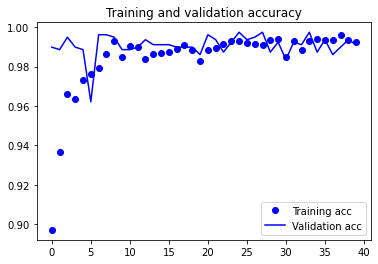

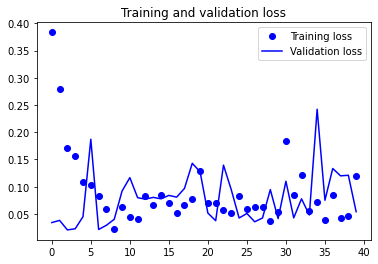

In [4]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()